In [84]:
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import time
import numpy as np




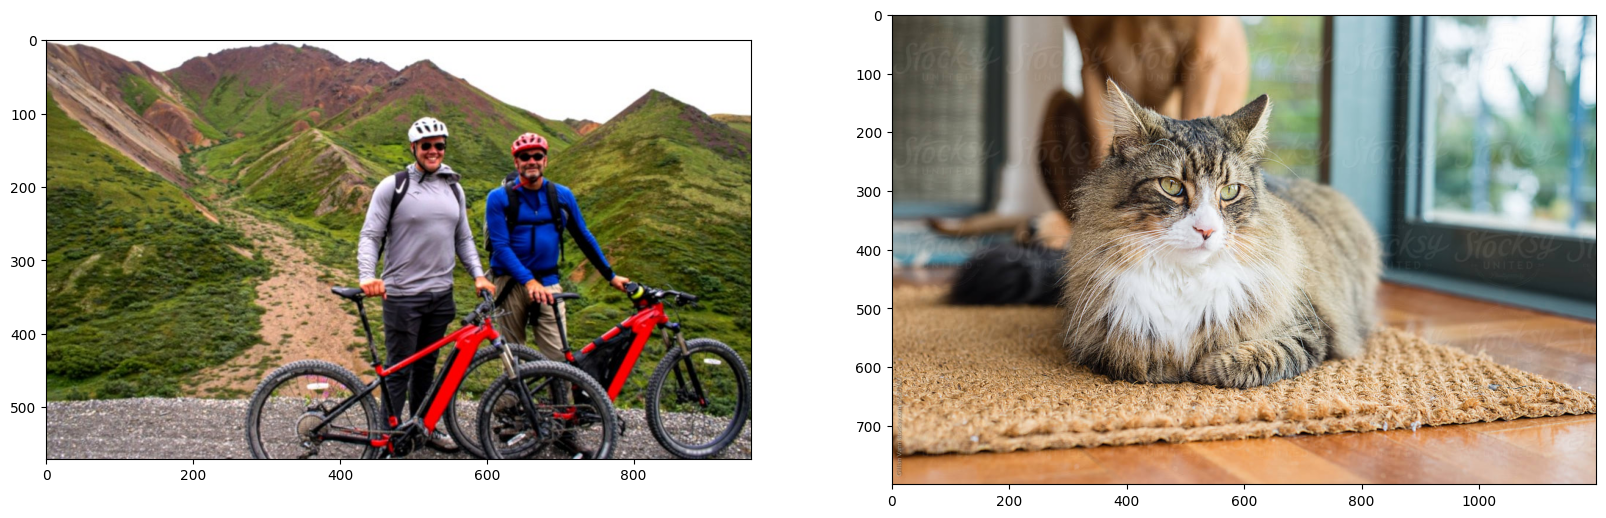

In [85]:
image1 = Image.open("bike.jpg")
image2 = Image.open("cat.jpg")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image1)
ax2.imshow(image2)

In [86]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [87]:
def extract_features(image_path: str, model, adaptive_pool):
    input_tensor = load_image(image_path)   
    with torch.no_grad():
        features = model(input_tensor)
        features = adaptive_pool(features)
        flattened_features = torch.flatten(features, start_dim=1)
    return features.squeeze().cpu().numpy(), flattened_features.squeeze().cpu().numpy()

In [88]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg19(pretrained=True).features
model.eval()
for param in model .parameters():
    param.requires_grad_(False)
adaptive_pool = torch.nn.AdaptiveAvgPool2d((12, 12))


torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_peak_memory_stats()


start_time = time.time()
image_path = "cat.jpg" 
embedding_vector,flatten = extract_features(image_path, model, adaptive_pool)
end_time = time.time()
runtime = end_time - start_time
max_memory_allocated = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
peak_memory_allocated = torch.cuda.max_memory_reserved(device) / (1024 ** 2)

print(f"Runtime: {runtime:.4f} seconds")
print(f"Max Memory Allocated: {max_memory_allocated:.2f} MB")
print(f"Peak Memory Allocated: {peak_memory_allocated:.2f} MB")

print(f"Feature Vector Dimension: {embedding_vector.shape}, Flatten vector: {flatten.shape}")


image_path = "bike.jpg" 
embedding_vector,flatten = extract_features(image_path, model, adaptive_pool)
print(f"Feature Vector Dimension: {embedding_vector.shape}, Flatten vector: {flatten.shape}")


Runtime: 0.6801 seconds
Max Memory Allocated: 9.00 MB
Peak Memory Allocated: 20.00 MB
Feature Vector Dimension: (512, 12, 12), Flatten vector: (73728,)
Feature Vector Dimension: (512, 12, 12), Flatten vector: (73728,)


In [89]:
runtimes = []
max_memory_allocated_list = []
peak_memory_allocated_list = []
for i in range(10):
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_peak_memory_stats()

    start_time = time.time()

    embedding_vector, flatten = extract_features(image_path, model, adaptive_pool)

    end_time = time.time()
    runtime = end_time - start_time
    runtimes.append(runtime)

    max_memory_allocated = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
    peak_memory_allocated = torch.cuda.max_memory_reserved(device) / (1024 ** 2)
    
    max_memory_allocated_list.append(max_memory_allocated)
    peak_memory_allocated_list.append(peak_memory_allocated)


average_runtime = np.mean(runtimes)
average_max_memory = np.mean(max_memory_allocated_list)
average_peak_memory = np.mean(peak_memory_allocated_list)
print("\nSummary of 10 Runs:")
print(f"Average Runtime: {average_runtime:.4f} seconds")
print(f"Average Max Memory Allocated: {average_max_memory:.2f} MB")
print(f"Average Peak Memory Allocated: {average_peak_memory:.2f} MB")


Summary of 10 Runs:
Average Runtime: 0.8490 seconds
Average Max Memory Allocated: 9.00 MB
Average Peak Memory Allocated: 20.00 MB
